# 0. Setup Paths

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH+'/pre-trained-models'
CONFIG_PATH = MODEL_PATH+'/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH+'/my_ssd_mobnet/'

# 1. Create Label Map

In [2]:
labels = [{'name':'Airline_name', 'id':1}, {'name':'Passenger_name', 'id':2},{'name':'Gate_no', 'id':3},{'name':'Flight_no', 'id':4}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

FileNotFoundError: [Errno 2] No such file or directory: 'Tensorflow/workspace/annotations\\label_map.pbtxt'

# 2. Create TF records

In [7]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [8]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  20% (597/2871)
Updating files:  21% (603/2871)
Updating files:  22% (632/2871)
Updating files:  23% (661/2871)
Updating files:  24% (690/2871)
Updating files:  25% (718/2871)
Updating files:  26% (747/2871)
Updating files:  27% (776/2871)
Updating files:  28% (804/2871)
Updating files:  29% (833/2871)
Updating files:  30% (862/2871)
Updating files:  31% (891/2871)
Updating files:  32% (919/2871)
Updating files:  33% (948/2871)
Updating files:  34% (977/2871)
Updating files:  35% (1005/2871)
Updating files:  36% (1034/2871)
Updating files:  37% (1063/2871)
Updating files:  38% (1091/2871)
Updating files:  39% (1120/2871)
Updating files:  40% (1149/2871)
Updating files:  41% (1178/2871)
Updating files:  42% (1206/2871)
Updating files:  43% (1235/2871)
Updating files:  44% (1264/2871)
Updating files:  44% (1273/2871)
Updating files:  45% (1292/2871)
Updating files:  46% (1321/2871)
Updating files:  47% (1350/2871)
Updating files:  48% (1379/2871)


In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [10]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [12]:
PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'

'Tensorflow/workspace/pre-trained-models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'

In [11]:
MODEL_PATH+'/'+CUSTOM_MODEL_NAME

'Tensorflow/workspace/models/my_ssd_mobnet'

# 5. Update Config For Transfer Learning

In [3]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [4]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [5]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [14]:
config

{'model': ssd {
   num_classes: 4
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 4e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.01
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.997
         scale: true
         epsilon: 0.001
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matcher {
     argmax_matcher {
       matched_threshold: 0.5
    

In [17]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [18]:
pipeline_config.model.ssd.num_classes = 4
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [19]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [20]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=5000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=5000


# 7. Load Train Model From Checkpoint

In [9]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [12]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [13]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-4')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Detect in Real-Time

(1, 1018, 1502, 3)


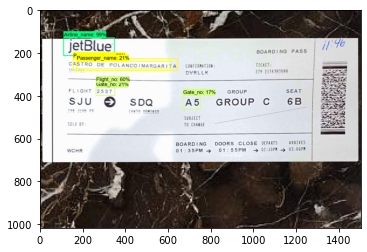

In [15]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('2.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.15,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

(1, 622, 932, 3)


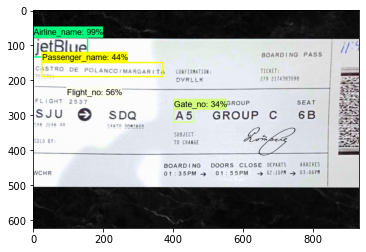

In [16]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('5.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.3,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

(1, 596, 1192, 3)


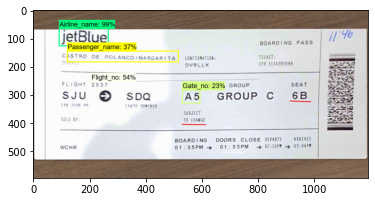

In [17]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('18.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.2,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()s

(1, 769, 1539, 3)


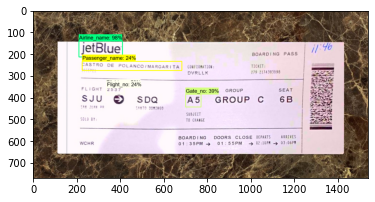

In [25]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('4.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.2,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
import easyocr

In [27]:
detection_threshold = 0.23

In [28]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [34]:
classes

array([0, 3, 2, 3, 1], dtype=int64)

In [32]:
len(classes)

5

In [33]:
boxes

array([[0.18548898, 0.13654852, 0.2783707 , 0.26746684],
       [0.45214722, 0.21776229, 0.49410984, 0.2721644 ],
       [0.502461  , 0.4554368 , 0.5765181 , 0.50192815],
       [0.46306485, 0.21963441, 0.50529677, 0.2729615 ],
       [0.30688986, 0.14620702, 0.3600078 , 0.44471508]], dtype=float32)

In [29]:
width = image.shape[1]
height = image.shape[0]

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0
[0.18548898 0.13654852 0.2783707  0.26746684]
[142.64102869 210.14817095 214.06707463 411.63147157]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3, 0], [201, 0], [201, 70], [3, 70]], 'jetBlue]', 0.7329080615278173)]
1
[0.45214722 0.21776229 0.49410984 0.2721644 ]
[347.7012088  335.13616651 379.97046635 418.86101836]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3, 7], [71, 7], [71, 27], [3, 27]], '2 5 3 7', 0.947020934096161)]
2
[0.502461   0.4554368  0.5765181  0.50192815]
[386.39252144 700.91722897 443.34243304 772.46742386]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[5, 5], [71, 5], [71, 45], [5, 45]], 'As', 0.858100698683961)]
3
[0.46306485 0.21963441 0.50529677 0.2729615 ]
[356.09686917 338.01736271 388.57321364 420.08774436]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [67, 0], [67, 19], [0, 19]], '2 5 3 7', 0.9867746995390473)]
4
[0.30688986 0.14620702 0.3600078  0.44471508]
[235.99830374 225.0126033  276.84599259 684.41651219]
[([[0, 0], [100, 0], [100, 28], [0, 28]], 'CASTRO', 0.5170436914577159), ([[112, 6], [150, 6], [150, 30], [112, 30]], 'DE', 0.9332545897866594), ([[163, 4], [288, 4], [288, 35], [163, 35]], 'POLANCO', 0.8512338434910229), ([[296, 12], [448, 12], [448, 38], [296, 38]], 'MARGAR TA', 0.7841798650932646)]


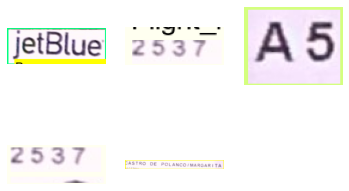

In [40]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(idx)
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    rows = 2
    plt.subplot(rows,3,idx+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

(1, 596, 1192, 3)


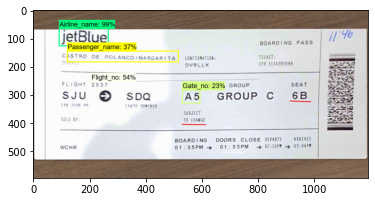

In [42]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('18.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.2,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0
[0.11136371 0.07760333 0.2119487  0.225315  ]
[ 66.37277055  92.50317258 126.32142091 268.57548547]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [176, 0], [176, 60], [0, 60]], 'ljetBlue', 0.4694819993782608)]
1
[0.42777503 0.17362934 0.46890473 0.23040819]
[254.95391512 206.96617746 279.46722126 274.64656448]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [62, 0], [62, 24], [0, 24]], '2 5 3 7', 0.8999841799737238)]
2
[0.24500194 0.10229604 0.30848148 0.43433863]
[146.02115738 121.93687904 183.85496485 517.73164606]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[8, 6], [74, 6], [74, 30], [8, 30]], 'StRo', 0.3432838022708893), ([[85, 9], [119, 9], [119, 29], [85, 29]], 'DE', 0.9262738460628931), ([[129, 7], [388, 7], [388, 36], [129, 36]], 'POLANCO / MARGARITA', 0.3863470657907717)]
3
[0.4778146  0.44469568 0.5537906  0.4990925 ]
[284.7775104  530.07725215 330.05921483 594.91824746]
[([[7, 5], [64, 5], [64, 41], [7, 41]], 'A5', 0.75102830729559)]


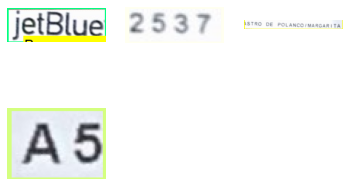

In [43]:
import easyocr
detection_threshold = 0.22
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(idx)
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    rows = 2
    plt.subplot(rows,3,idx+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

(1, 769, 1539, 3)


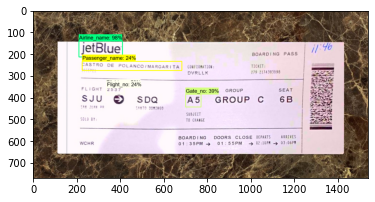

In [44]:
#IMAGE_PATH = os.path.join('stimg1.jpg')
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


img = cv2.imread('4.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
print(input_tensor.shape)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()


viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.2,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


0
[0.18548898 0.13654852 0.2783707  0.26746684]
[142.64102869 210.14817095 214.06707463 411.63147157]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3, 0], [201, 0], [201, 70], [3, 70]], 'jetBlue]', 0.7329080615278173)]
1
[0.45214722 0.21776229 0.49410984 0.2721644 ]
[347.7012088  335.13616651 379.97046635 418.86101836]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[3, 7], [71, 7], [71, 27], [3, 27]], '2 5 3 7', 0.947020934096161)]
2
[0.502461   0.4554368  0.5765181  0.50192815]
[386.39252144 700.91722897 443.34243304 772.46742386]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[5, 5], [71, 5], [71, 45], [5, 45]], 'As', 0.858100698683961)]
3
[0.46306485 0.21963441 0.50529677 0.2729615 ]
[356.09686917 338.01736271 388.57321364 420.08774436]


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [67, 0], [67, 19], [0, 19]], '2 5 3 7', 0.9867746995390473)]
4
[0.30688986 0.14620702 0.3600078  0.44471508]
[235.99830374 225.0126033  276.84599259 684.41651219]
[([[0, 0], [100, 0], [100, 28], [0, 28]], 'CASTRO', 0.5170436914577159), ([[112, 6], [150, 6], [150, 30], [112, 30]], 'DE', 0.9332545897866594), ([[163, 4], [288, 4], [288, 35], [163, 35]], 'POLANCO', 0.8512338434910229), ([[296, 12], [448, 12], [448, 38], [296, 38]], 'MARGAR TA', 0.7841798650932646)]


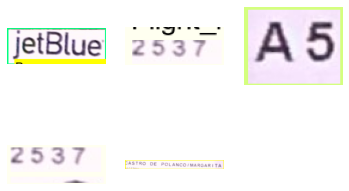

In [45]:
import easyocr
detection_threshold = 0.22
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]
width = image.shape[1]
height = image.shape[0]
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    print(idx)
    print(box)
    roi = box*[height, width, height, width]
    print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    reader = easyocr.Reader(['en'])
    ocr_result = reader.readtext(region)
    print(ocr_result)
    rows = 2
    plt.subplot(rows,3,idx+1)
    plt.axis('off')
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))